In [1]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 2D Surface Trap example
SimpleTrap

In [14]:
import sys
import logging, os
from time import time
import numpy as np
# Importing pyface.qt is for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# which is incompatible with "pyside" in package "mayavi". Python 2.
# import pyface.qt    
import matplotlib.pyplot as plt
from multiprocess import Pool # rather than import multiprocessing to work with jupyter

sys.path.append('../../')   # add path of package "bem" to search list.
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list.

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

import numpy as np

In [15]:
help(Mesh)

Help on class Mesh in module bem.triangulation:

class Mesh(collections.OrderedDict)
 |  A Mesh is a mapping of electrode names to list of faces
 |  
 |  Method resolution order:
 |      Mesh
 |      collections.OrderedDict
 |      builtins.dict
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  areas_from_constraints(self, constraints)
 |      set max triangle areas for subsequent triangulations
 |  
 |  check(self)
 |      verifies that points, triangles are superficially consistent
 |      call gather() before this.
 |  
 |  fastlap_points(self)
 |      returns a point array suitable for fastlap, fastlap likes
 |      points clockwise, triangle and vtk like them counterclockwise
 |  
 |  gather(self)
 |      concatenate points and triangles from the individual faces and
 |      generates group markers (indices into the electrode
 |      names/self.keys())
 |  
 |  plot(self, ax, *args, **kwargs)
 |      plot mesh
 |  
 |  set_max_areas(self, max_areas)
 |  
 |  to_polyd

### Import STL geometry file

In [16]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    # This notebook is the same as SeidelinTrap.ipynb except for the redrawed stl file.
    prefix = "SimpleTrap"
suffix = ""

print(prefix)

SimpleTrap


At first coding number of electrode colors are unknown, users need to specify an arbitrary rename argument as a first attempt, then `stl.stl_to_mesh()` will drop unnamed coding numbers below for next formal rename.

In [17]:
# scale to natural units (ion height)
scale = 40e-6    # Distance from ion to electrode is 40 um.
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    # s_nta is intermediate processed stl file.
    s_nta = stl.read_stl(open("%s.stl" % prefix, "rb"))
    print("Import stl:",os.path.abspath("./"+prefix+".stl"),"\n")
    print("Electrode colors (numbers):\n")
    stl.stl_to_mesh(*s_nta, scale=scale/1e-6,rename={-1:""})

Import stl: /Users/yizhu/Desktop/bem/examples/SimpleTrap/SimpleTrap.stl 

Electrode colors (numbers):

dropping 0
dropping 9495
dropping 17962
dropping 18994
dropping 18869
dropping 20943
dropping 18129


The formal rename of electrode. Assign each electrode a string name instead of its color coding. Use the numbers you get above.  
`stl.stl_to_mesh()` prints normal vectors (different faces) in each electrode.

In [18]:
print(len(s_nta), type(s_nta),"\n")
# s_nta is a length 3 tuple. (normal, triangle, attribute) 
# Normal direction of each triangle, three vetices of triangles, coding number of colors.

# 0 is color for space between electrodes

print("Triangles:",len(s_nta[0]),"\nColors:",len(np.unique(s_nta[2])),"\n")    

# stl_to_mesh() only assigns names and does scaling, doing no triangulation to stl mesh.
# "scale=scale/1e-6" only scales dimensionless scale/1e-6.    1e-6: if stl uses micron as unit. 
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,
    rename={9495: "DC1", 17962: "DC3", 18994: "DC5",18869: "DC2", 20943: "RF", 18129: "DC4"}, quiet=False))    
    # 0:Black, 28165:Cyran, 1882:Yello, 1633:Dark Green, 1530:Orange, 8456:Dark Gray, 24:Red, 24311:Default

3 <class 'tuple'> 

Triangles: 440 
Colors: 7 

dropping 0
1 planes in electrode DC1
normals vectors:
 [[ 0. -0.  1.]]
1 planes in electrode DC3
normals vectors:
 [[0. 0. 1.]]
1 planes in electrode DC5
normals vectors:
 [[0. 0. 1.]]
1 planes in electrode DC2
normals vectors:
 [[0. 0. 1.]]
1 planes in electrode RF
normals vectors:
 [[0. 0. 1.]]
1 planes in electrode DC4
normals vectors:
 [[ 0. -0.  1.]]


### Generate triangle mesh with constraints

The meshes are 2-dimensional triangles on the surface of electrodes. The region enclosed by constraint shape can have finer mesh. Triangulation is done by `triangle` C library.

Output vtk: /Users/yizhu/Desktop/bem/examples/SimpleTrap/SimpleTrap.vtk


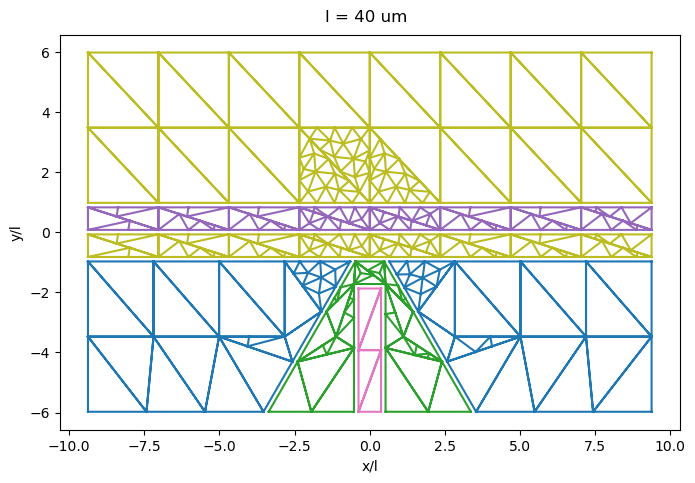

In [20]:
# set .1 max area within 3
# areas_from_constraints specifies sphere with finer mesh inside it.
# "inside", "outside" set different mesh densities.
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),
           radius=2, inside=0.2, outside=10))    

# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix+suffix)
print("Output vtk:",os.path.abspath("./"+prefix+suffix+".vtk"))    # output path

# Plot triangle meshes.
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(8,6), dpi=100)
ax.set_xlabel("x/l",fontsize=10)
ax.set_ylabel("y/l",fontsize=10)
ax.text(-1.5,7,"l = %d um"%(scale/1e-6),fontsize=12)
mesh.plot(ax)

### Main boundary element calculations

In `run_job` function, `job` is `Configuration` instance and `grid` is discretirized spatial grid (not the mesh). The general workflow (also the routine of BEM method) are:  
1. `solve_singularities()` solves charge distributions by iterative methods to make it consistent with one electrode at 1V and others at 0V (unit potentials). `adapt_mesh()` refines meshes adaptively to achieve certain precision while solving sigulartities.
2. Compute potentials on given grid points by `simulate()`, based on the charge distributions gotten previously.
3. Potential data of each unit potential are saved seperately to a `Result` instance, and also export to VTK files.
4. Return total accumulated charge per electrode in the end.

Major calculations calls `fastlap` C library which uses a pre-conditioned, adaptive, multipole-accelerated algorithm for solving Laplace problem. Two parameters control multipole acceleration.
+ num_mom, the number of multipole
+ num_lev, the number of levels in the hierarchical spatial decomposition.  
num_lev=1 means direct computation without multipole acceleration. See fastlap ug.pdf and README.rst.

In [7]:
# Define calculation function.
def run_job(args):
    # job is Configuration instance.
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min angle 25 deg.
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for surface charges
    job.solve_singularities(num_mom=4, num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=2)    # For "RF", field=True computes the field.
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

Create a grid in unit of scaled length `l`. Only choose the interested region (trap center) to save time.

For reference, to compute Seidelin trap, grid shape = (60, 60, 60) takes 266 s, while shape = (150, 150, 150) takes 3369 s.

In [8]:
# grid to evalute potential and fields at. Create a grid in unit of scaled length l. Only choose the interested region (trap center) to save time.
n, s = 2*10, 0.08
Lx, Ly, Lz = 2, 2, 2    # in the unit of scaled length l
sx, sy, sz = s, s, s
# ni is grid point number, si is step size. Thus to fix size on i direction you need to fix ni*si.
nx, ny, nz = [2*np.ceil(L/2.0/s).astype('int') for L in (Lx, Ly, Lz)]
print("Size/l:", Lx, Ly, Lz)
print("Step/l:", sx, sy, sz)
print("Shape (grid point numbers):", nx, ny, nz)
grid = Grid(center=(0, 0, 1.5), step=(sx, sy, sz), shape=(nx, ny, nz))
# Grid center (nx, ny ,nz)/2 is shifted to origin
print("Grid origin/l:", grid.get_origin()[0])

Size/l: 2 2 2
Step/l: 0.08 0.08 0.08
Shape (grid point numbers): 26 26 26
Grid origin/l: -1.0


Calculation. Parallel computation `Pool().map`

In [11]:
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() picks one electrode each time.
# run the different electrodes on the parallel pool
pmap = Pool().map # parallel map
# pmap = map # serial map
t0 = time()

list(pmap(run_job, ((job, grid, prefix+suffix) for job in jobs)))
print("Computing time: %f s"%(time()-t0))
# run_job casts a word after finishing each electrode.

<generator object <genexpr> at 0x7fda34373350>
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.02951
FLW-placeq: oversized panel, cube length=2.27936 panel length=2.9032
FLW-placeq: oversized panel, cube length=2.27936 panel length=2.9032
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.27936 panel length=2.5
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.02951
FLW-placeq: oversized panel, cube length=2.27936 

finished job DC5
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.02951
FLW-placeq: oversized panel, cube length=2.27936 panel length=2.9032
FLW-placeq: oversized panel, cube length=2.27936 panel length=2.9032
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.27936 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.27936 panel length=2.5
FLW-placeq: oversized panel, cube length=2.32661 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.32661 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.32661 panel length=3.02951
FLW-placeq: oversized panel, cube length=2.32661 panel length=2.9032
FLW-placeq

### Contour plot of potential/pseudo-potential in 3 directions

p max 0.29038583595
yz plane, RF pseudo


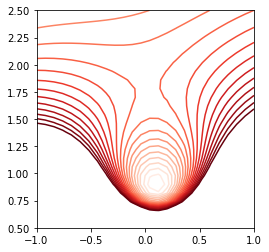

In [25]:
# isocontour plot of RF pseudopotential radially from x (axial) direction
result = Result.from_vtk(prefix+suffix, "RF")
p = result.pseudo_potential
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:, p.shape[0]//2]    # p.shape[0]/2 is in the middle of x.
p = p[p.shape[0]//2]    # get a slice of yz plane at x = p.shape[0]/2.
print("yz plane, RF pseudo")
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds) 

p max 0.32429348656
yz plane, DC1 potential


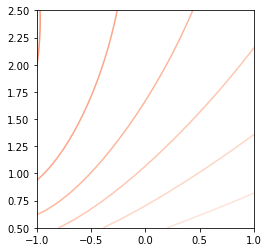

In [25]:
# isocontour plot of DC potential from x (axial) direction
ele = "DC1"
result = Result.from_vtk(prefix+suffix, ele)
p = result.potential
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:,p.shape[0]//2]
p = p[p.shape[0]//2]
print("yz plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
ax.contour(x[1], x[2], p, levels=np.linspace(0, maxp, 20), cmap=plt.cm.Reds)    # 2e-2

p max 0.29003028707
xy plane, RF potential


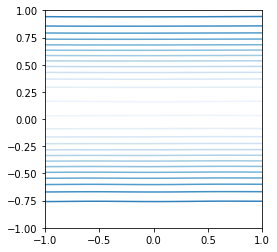

In [40]:
# isocontour plot of electrode potential (electrode profile) from z direction
ele = "RF"
result = Result.from_vtk(prefix+suffix, ele)
p = result.pseudo_potential
maxp = np.amax(p)
print("p max", maxp)
coord = grid.to_mgrid()
x = coord[:,:,:,p.shape[2]//2-10]
p = p[:,:,p.shape[2]//2-10]
print("xy plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp/2, 20), cmap=plt.cm.Blues)

p max 0.32429348656
xz plane, DC1 potential


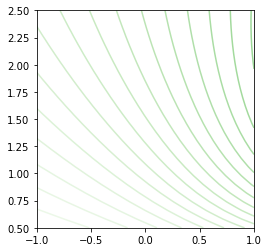

In [12]:
# isocontour plot of single DC potential from y direction
ele = "DC1"
result1 = Result.from_vtk(prefix+suffix, ele)
p = result.potential
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:,:,p.shape[1]//2]
p = p[:,p.shape[1]//2]
print("xz plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Greens)

In [14]:
result = Result.from_vtk(prefix+suffix, "DC1")
p = result.potential
print(coord.shape)    # length nx, ny, nz
print(coord[:,p.shape[0]//2].shape)    # plane at nx/2
print(p.shape)

(3, 26, 26, 26)
(3, 26, 26)
(26, 26, 26)


### 3D plot of mesh and potential isocontour
By mayavi GUI (seems to have problem now.)

In [16]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix+suffix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

# Can't lauch GUI through X11 remote and caused dead kernel.

## Data processing
Using `electrode` package. (`GridElectrode.from_result()` method has problems for now, use `from_vtk()` directly.)  
I perfer to split data processing part to a new notebook. See `DataProcessing_SE.ipynb`.

In [17]:
# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 RF".split():
    r = Result.from_vtk(prefix+suffix, name)
    e = GridElectrode.from_result(r,maxderiv=4)
#     e = GridElectrode.from_vtk("%s%s_"%(prefix,suffix)+name+".vtk",maxderiv=4)
    e.name = name
    s.append(e)

In [18]:
import scipy.constants as ct
l = 40e-6 # length scale
u = 103.25 # peak rf voltage
o = 87e6*2*np.pi # rf frequency
m = 24.3*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
# coefficient of pseudo-potential. See blakestad2010 Eq.(5.2). Run rf_scale() before other calculations.
rf_scale = s.rf_scale(m,q,l,o)

s["RF"].rf = 25. # peak rf voltage
method = 'Newton-CG'
x0 = s.minimum((0, 0, 1.),method=method)
for _ in s.analyze_static(x0, m=m, l=l, o=o, min_method=method):
    print(_)

parameters:
 f=87 MHz, m=24.3 amu, q=1 qe, l=40 µm, scale=0.0456 V'/V_SI
corrdinates:
 analyze point: [-1.15185129e-04  1.00069911e-01  8.96291594e-01]
               ([-4.60740517e-03  4.00279644e+00  3.58516638e+01] µm)
 minimum is at offset: [ 3.33886059e-08 -3.85466850e-09  2.03160342e-06]
                      ([ 1.33554424e-06 -1.54186740e-07  8.12641368e-05] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 4.7e-08 eV
 saddle offset: [-3.48515024e-02 -6.89511050e-05 -2.64391931e-05]
               ([-1.39406010e+00 -2.75804420e-03 -1.05756772e-03] µm)
 saddle height: 1.7e-10 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [-1.25425887e-08  1.44802456e-09 -7.63181492e-07] eV/l
           ([-3.13564718e-04  3.62006141e-05 -1.90795373e-02] eV/m)
modes:
 pp+dc normal curvatures: [-4.25995291e-07  3.75746600e-01  3.75797415e-01]
 motion is bounded: True
 pseudopotential modes:
  a: nan MHz, [9.99997739e-01 1.97431225e-03 7.90247094e-04]
  b: 4.86 

../../../electrode/electrode/system.py:1020: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)


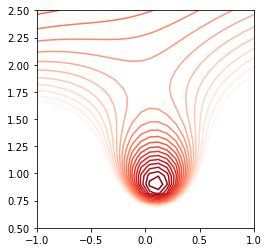

In [20]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)